In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.metrics import mean_squared_error
#mounting to drive
from google.colab import drive
drive.mount('/content/gdrive')
!pip install livelossplot
import sys
# Add the tools directory to the system path
tools_path = 'gdrive/MyDrive/Colab Notebooks/'
if tools_path not in sys.path:
    sys.path.append(tools_path)

from tools import *

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    print("Cuda installed! Running on GPU!")
    print(torch.cuda.get_device_name())
else:
    print("No GPU available! Running on CPU")

Cuda installed! Running on GPU!
Tesla T4


# Load the data and resample and reshape

We first start by loading our data and pre-processing it. <br>
Since the time steps for the training/testing dataset and the backgrounds/observations datasets are different - that is delta t = 1 for the former pair and delta t = 10 for the latter - there were 2 options: <br>
- resampling the training/testing dataset, by taking every 10th image before training on it <br>
- running the model on the background/observations dataset 10 times <br>
<br>
The training loss and error we obtained after we tried the first option were satisfying so we decided to proceed with it. <br>
The second option, given it being an iterative process with re-iterated results - could affect the accuracy of the results. And so we discarded it.

In [ ]:
train_path = 'Data/Ferguson_fire_train.npy'
test_path = 'Data/Ferguson_fire_test.npy'
background_path = 'Data/Ferguson_fire_background.npy'

train_data = load_data(train_path)
test_data = load_data(test_path)
background_data = load_data(background_path)

print(f"Original train shape: {train_data.shape}")
print(f"Original test shape: {test_data.shape}")
print(f"Original background shape: {background_data.shape}")

train_1D = preprocess_data(train_data)
test_1D = preprocess_data(test_data)

print(f"Train shape after resampled and reshaped to: {train_1D.shape}")
print(f"Test shape after resampled and reshaped to: {test_1D.shape}")

In [15]:
train_path = 'gdrive/MyDrive/Colab Notebooks/Ferguson_fire_train.npy'
test_path = 'gdrive/MyDrive/Colab Notebooks/Ferguson_fire_test.npy'
background_path = 'gdrive/MyDrive/Colab Notebooks/Ferguson_fire_background.npy'

train_data = load_data(train_path)
test_data = load_data(test_path)
background_data = load_data(background_path)

print(f"Original train shape: {train_data.shape}")
print(f"Original test shape: {test_data.shape}")
print(f"Original background shape: {background_data.shape}")

train_1D = preprocess_data(train_data)
test_1D = preprocess_data(test_data)

print(f"Train shape after resampled and reshaped to: {train_1D.shape}")
print(f"Test shape after resampled and reshaped to: {test_1D.shape}")

Original train shape: (12500, 256, 256)
Original test shape: (5000, 256, 256)
Original background shape: (5, 256, 256)
Train shape after resampled and reshaped to: (1250, 1, 256, 256)
Test shape after resampled and reshaped to: (500, 1, 256, 256)


# Explore the data

The preprocessed data is comprised of 0s and 1s, where 0 means "no fire" and 1 means "fire". <br>

We therefore plotted the number of elements with value 1 at each time step. The higher the bar is, the larger the area on fire at that time step.


When observing the data distribution per time step in both the original and the resampled train/test dataset, we can see that after re-sampling every 10th data point, the distribution was not affected - which also re-inforced our decision to opt with this first option of resampling.

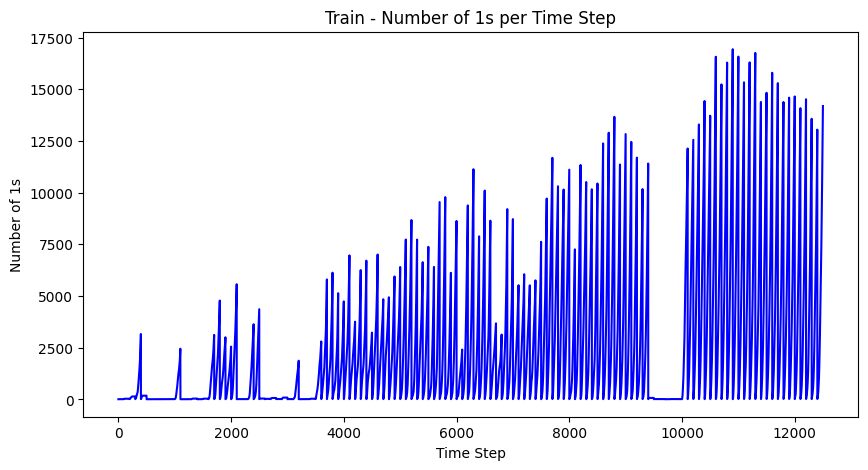

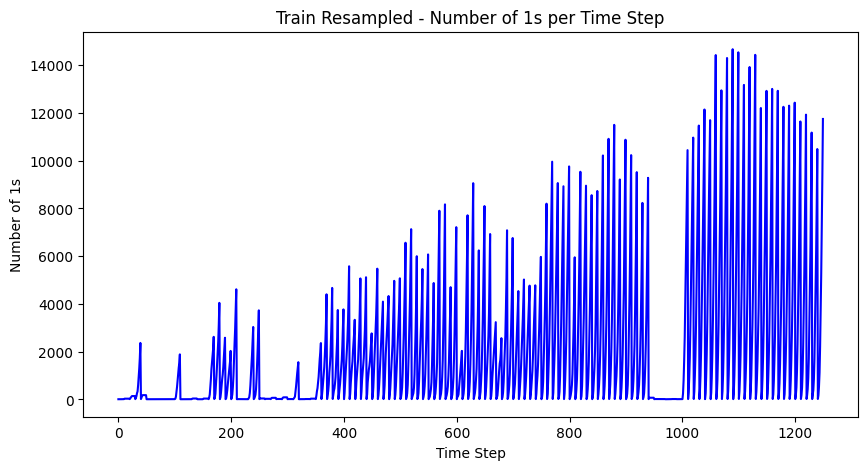

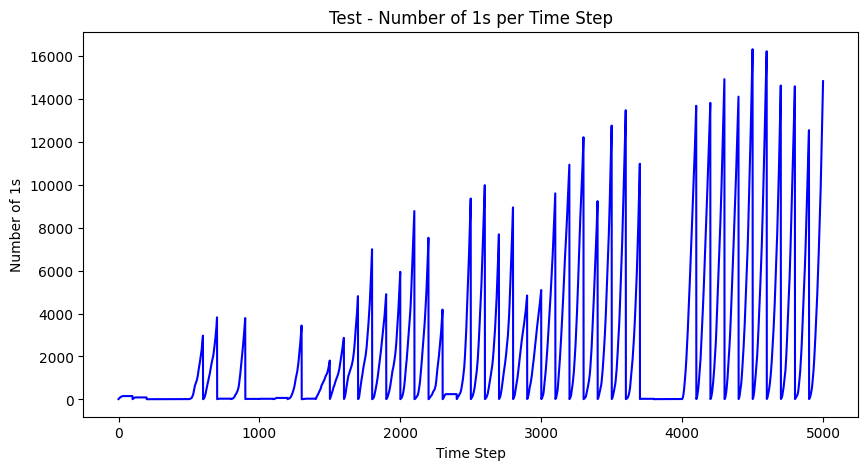

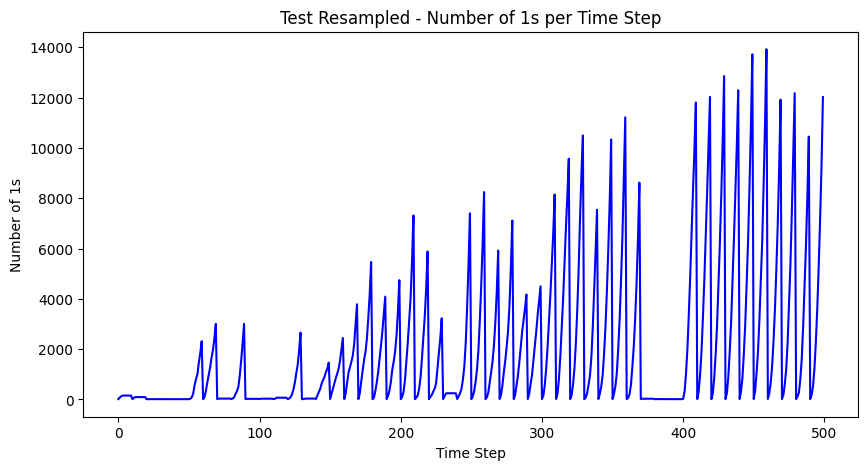

In [16]:
plot_fire_counts(train_data, 'Train - Number of 1s per Time Step')
plot_fire_counts(train_data[::10], 'Train Resampled - Number of 1s per Time Step')
plot_fire_counts(test_data, 'Test - Number of 1s per Time Step')
plot_fire_counts(test_data[::10], 'Test Resampled - Number of 1s per Time Step')

## Step 1 - Use model data for training

As for the model of our choice, we ran a standard RNN model, a LSTM model and a LSTM combined with convolutional layers. <br>
The RNN model that gave us the best results in terms of training loss was comprised of an input layer, 3 layers of RNN cells each with a hidden state size of 200 and an output layer. <br>
<br>
![image.png](attachment:image.png)


And the following MSE results using the RNN model architecture: <br>

![image.png](attachment:image.png)

When trying a LSTM model, the results ended up being very similar. The training loss and the MSE were almost the same, so we chose the model that ran faster. <br>
The execution time of the RNN model was around 55 seconds and the execution time of the LSTM model was of 37 seconds. <br>
We therefore chose to proceed with the LSTM model. <br>
The LSTM model was improved by adding convolutional layers.

# Convolutional LSTM model

The final LSTM model therefore consists of a combination of CNN and LSTM networks to process sequences of images. <br>
This architecture helps tackle both the spatial and temporal aspects: CNNs for spatial feature extraction and LSTMs for temporal sequence modeling. <br>

The model is comprised of 16 convolutional filters, with a kernel size of 6. <br>
(Smaller kernel sizes such as 3 or 4 also give good results like 6, but we chose to keep 6 for it is not too small nor too big) <br>
And 2 layers of LSTM each with a hidden size of 350 - increasing the hidden size gave better loss results but led to overfitting so we stopped at this number. <br>
Adding or removing layers also made the results worse so 2 layers was the perfect balance.


## Processing the Dataset

## Dataloader

In [17]:
batch_size = 16
train_loader = create_dataloader(train_1D, batch_size=batch_size, shuffle=True)
test_loader = create_dataloader(test_1D, batch_size=batch_size, shuffle=False)

## Model Build

The model has been packaged in the .py file.

## Overall Model Parameters

In [18]:
input_channels = 1
conv_filters = 16  # was 16
conv_kernel_size = 6  # was 3, 4 also good
hidden_size = 350 # Reduce number of hidden units # 320 gives 0.0052, 150 gives 0.0065, 350 gives 0.0051, 420 gives 0.0049 but graph not better
num_layers = 2  # was 2, giving 0.0051, 2 is better than 3 or 1
output_size = 256 * 256
lr = 3e-4
num_epochs = 40
drop_out = 0

## Model, Loss Function and Optimizer - Initialization

In [19]:
model = ConvLSTMModel(input_channels, conv_filters, conv_kernel_size, hidden_size, num_layers, output_size, dropout_rate=drop_out).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

## Training and Validation

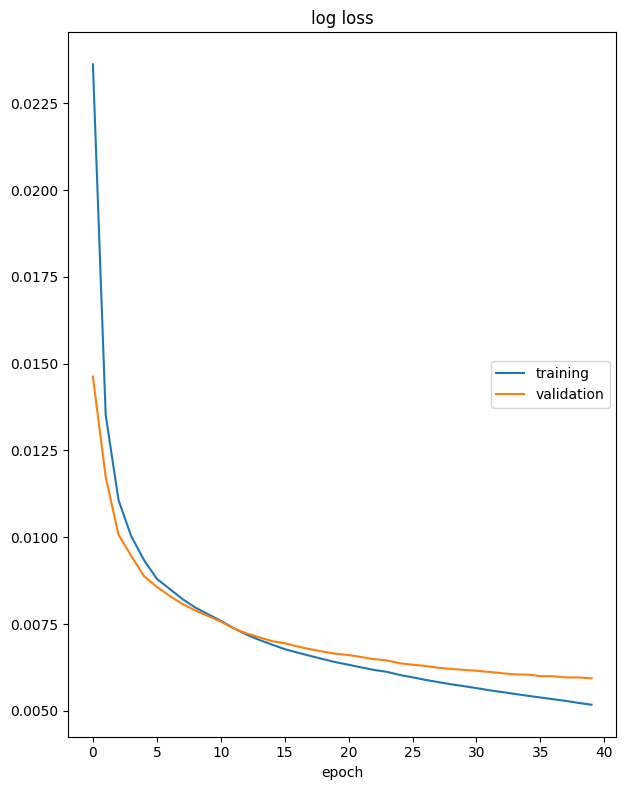

log loss
	training         	 (min:    0.005, max:    0.024, cur:    0.005)
	validation       	 (min:    0.006, max:    0.015, cur:    0.006)
Epoch 40/40, Train Loss: 0.0052, Validation Loss: 0.0059
Model saved to lstm_model.pth


In [20]:
train_and_validate(model, train_loader, test_loader, criterion, optimizer, num_epochs)

The train loss we have obtained using a convolutional LSTM model is better than any of the previous models we have tried.

## Loading the model

In [21]:
model.load_state_dict(torch.load('lstm_model.pth'))
print("Model loaded from lstm_model.pth")

Model loaded from lstm_model.pth


## Testing

In [22]:
test(model, test_loader, criterion)

Test Loss: 0.005937814


## Visualizing model generated images

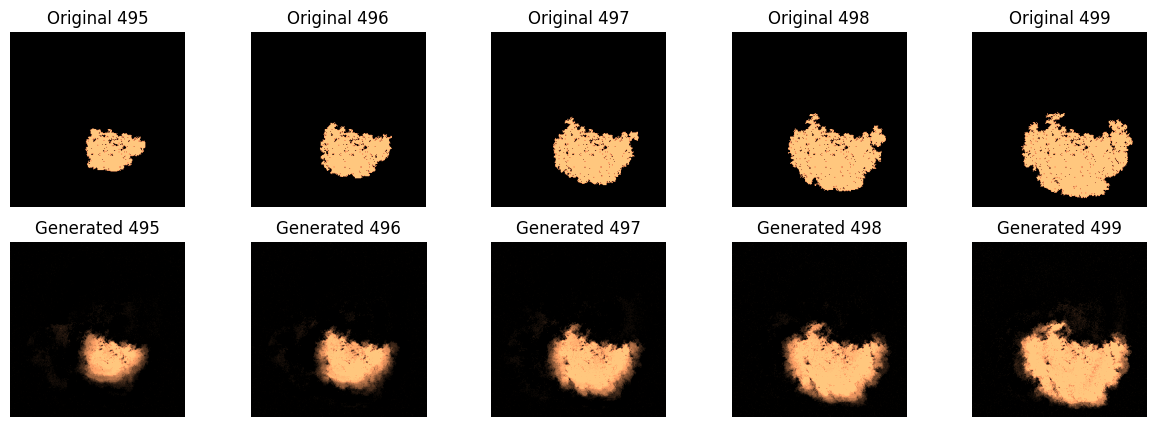

In [23]:
visualize_indices = [495, 496, 497, 498, 499]
visualize_predictions(model, test_loader.dataset, visualize_indices)

The above plot visually displays the performance of our model when feeding it images. <br>

# Step 2 - Use model to make a forecast

We are now feeding the model with background data in order to obtain a prediction.

In [24]:
predicted_backgrounds = predict_next_background(model, background_data)

In [25]:
save_predictions(predicted_backgrounds, 'LSTM_backgrounds.npy')
print("Predicted backgrounds saved to 'LSTM_backgrounds.npy'")

Predictions saved to LSTM_backgrounds.npy
Predicted backgrounds saved to 'LSTM_backgrounds.npy'


# Step 3 - Compare the forecast with satellite data

In [26]:
satellite_data = np.load('gdrive/MyDrive/Colab Notebooks/Ferguson_fire_obs.npy')
print(satellite_data.shape)

(5, 256, 256)


In [27]:
mse_values, average_mse = calculate_mse_1(predicted_backgrounds, satellite_data)
print(f"MSE for Predicted vs Satellite: {mse_values}")
print(f"Average MSE: {average_mse}")

MSE for Predicted vs Satellite: [0.03423235555852528, 0.049858732781121504, 0.062375101440481216, 0.07991125805558079, 0.10451989855677324]
Average MSE: 0.06617946927849641


We can see a slight improvement in the MSE values using our model compared to the RNN model.

In [28]:
mse_values, average_mse = calculate_mse_1(predicted_backgrounds, background_data)
print(f"MSE for Predicted vs Satellite: {mse_values}")
print(f"Average MSE: {average_mse}")

MSE for Predicted vs Satellite: [0.009435115, 0.012547583, 0.015811512, 0.018906657, 0.02288594]
Average MSE: 0.01591736078262329


Looking at the MSE values between the predicted images and the background data, gives an idea on how close they are to the background images - we get a smaller value compared to the satellite images. This makes sense since visually the background and satellite images are much more different.

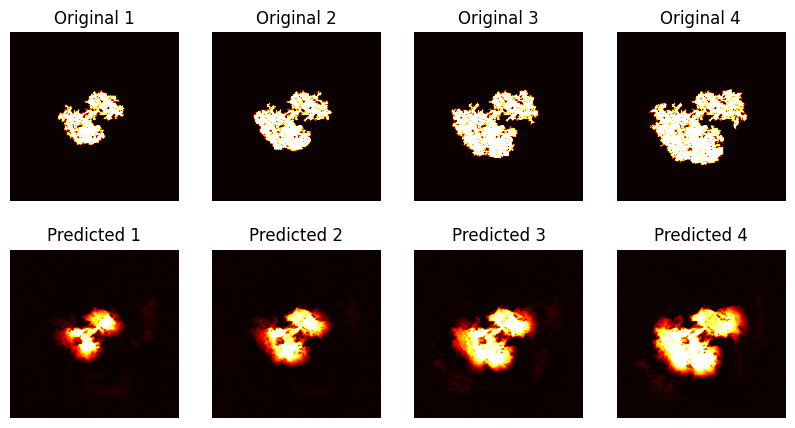

In [29]:
plt.figure(figsize=(10, 8))
for i in range(min(len(predicted_backgrounds), len(satellite_data) - 1)):
    plt.subplot(3, min(len(predicted_backgrounds), len(satellite_data) - 1), i + 1)
    plt.imshow(background_data[i+1], vmin=0, vmax=1, cmap='hot')
    plt.title(f'Original {i+1}')
    plt.axis('off')

    plt.subplot(3, min(len(predicted_backgrounds), len(satellite_data) - 1), i + 1 + min(len(predicted_backgrounds), len(satellite_data) - 1))
    plt.imshow(predicted_backgrounds[i], vmin=0, vmax=1, cmap='hot')
    plt.title(f'Predicted {i+1}')
    plt.axis('off')


plt.show()

In the above plot, feeding the original background image at index 0 generates the predicted image at index 1, called "Predict 1" <br>
The background image at index 1, called "Original 1" generates the predicted image at index 2, called "Predict 2" <br>
The background image at index 2, called "Original 2" generates the predicted image at index 3, called "Predict 3" <br>
The background image at index 3, called "Original 3" generates the predicted image at index 4, called "Predict 4" <br>

The predicted image of index 1 is then compared with the original image of index 1 to see how similar they are to each other. <br>
And so on with each predicted image. <br>
The MSE calculated above between the predicted images and observations translate this into numbers. The average MSE for the 4 images is of 0.068.